## Prostate MRI Demand

In [1]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# optional auto-ARIMA
try:
    from pmdarima import auto_arima
    HAS_PMDARIMA = True
except Exception:
    HAS_PMDARIMA = False

FILE_PATH = "TotalMRI_Timeseries.csv"


In [2]:
# Load and clean
df = pd.read_csv(FILE_PATH)

# strip names and values
df.columns = df.columns.str.strip()
df["Date"] = df["Date"].astype(str).str.strip()

# parse dates (DD/MM/YYYY)
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")

# ensure numeric
df["Total Prostate MRI"] = pd.to_numeric(df["Total Prostate MRI"], errors="coerce")

# drop bad rows and sort
df = df.dropna(subset=["Date", "Total Prostate MRI"]).sort_values("Date").reset_index(drop=True)


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\1455116075.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Date", freq="M"))["Total Prostate MRI"]


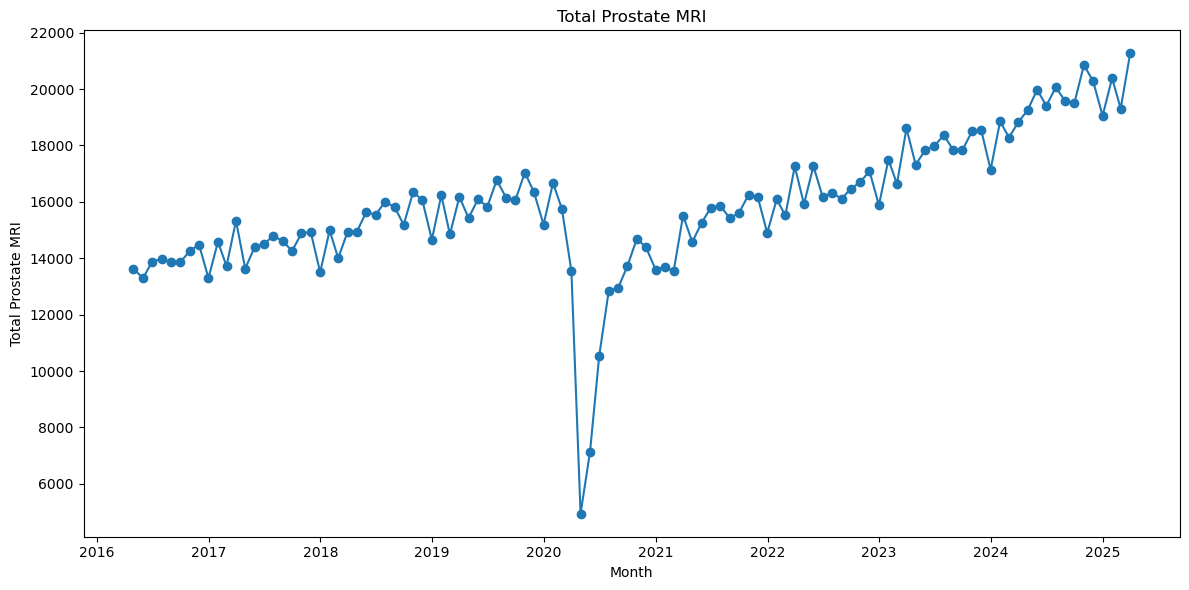

In [3]:
# Monthly aggregation and plot
df_monthly = (
    df.groupby(pd.Grouper(key="Date", freq="M"))["Total Prostate MRI"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly["Date"], df_monthly["Total Prostate MRI"], marker="o")
plt.title("Total Prostate MRI")
plt.xlabel("Month")
plt.ylabel("Total Prostate MRI")
plt.tight_layout()
plt.show()


### STL Decompostion

C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\2679556994.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df_monthly.set_index("Date")["Total Prostate MRI"].asfreq("M")


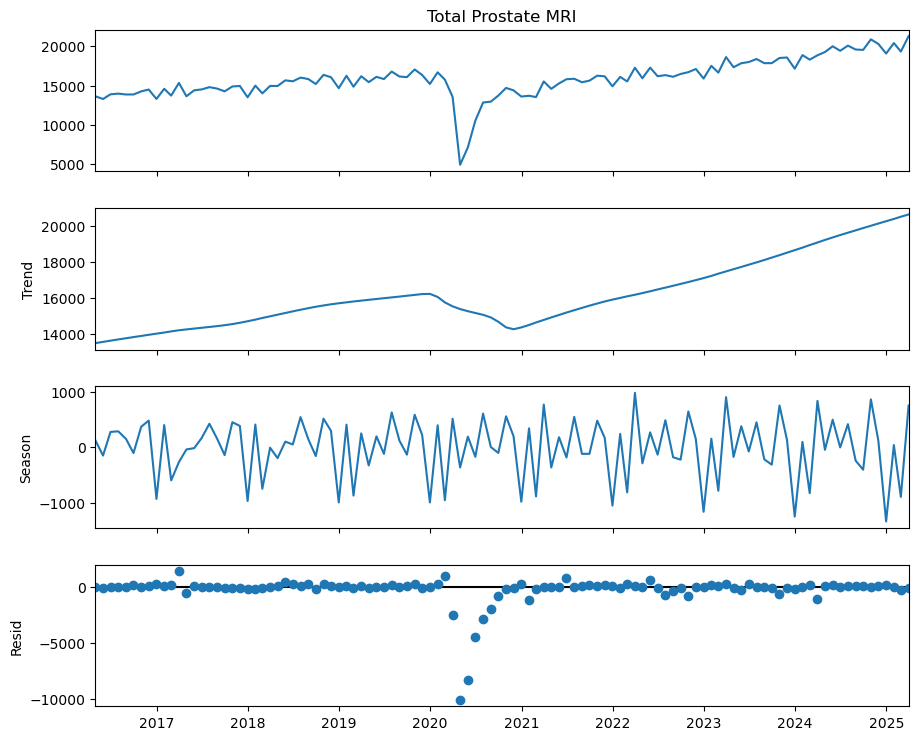

In [4]:
# STL decomposition
df_monthly["Date"] = pd.to_datetime(df_monthly["Date"])
df_monthly = df_monthly.sort_values("Date")
ts = df_monthly.set_index("Date")["Total Prostate MRI"].asfreq("M")

stl = STL(ts, period=12, robust=True)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()


### ADF test

In [5]:
# ADF test on original series
adf_result = adfuller(ts.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for k, v in adf_result[4].items():
    print(f"Critical Value ({k}): {v:.4f}")
print("Stationary" if adf_result[1] < 0.05 else "Not stationary")


ADF Statistic: -0.0760
p-value: 0.9518
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835
Not stationary


In [6]:
# First difference and ADF on differenced series
ts_diff = ts.diff().dropna()

adf_result_diff = adfuller(ts_diff)
print(f"ADF Statistic (1st diff): {adf_result_diff[0]:.4f}")
print(f"p-value (1st diff): {adf_result_diff[1]:.4f}")
for k, v in adf_result_diff[4].items():
    print(f"Critical Value ({k}): {v:.4f}")
print("Differenced series is stationary" if adf_result_diff[1] < 0.05 else "Differenced series is NOT stationary")


ADF Statistic (1st diff): -3.7855
p-value (1st diff): 0.0031
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835
Differenced series is stationary


### ACF and PACF Plots

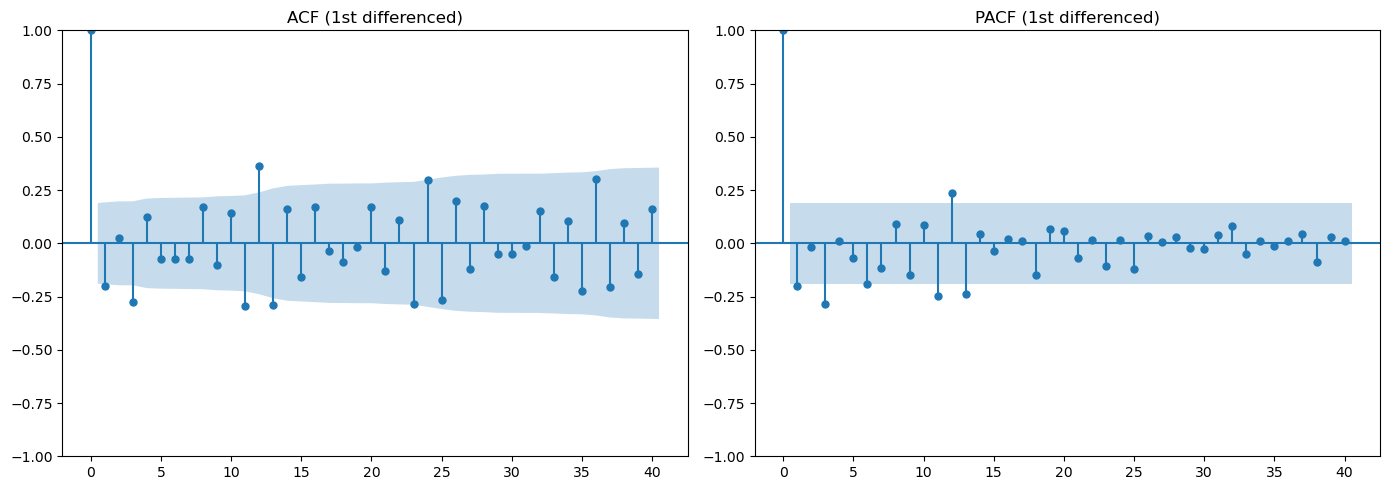

In [7]:
# ACF and PACF on differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(ts_diff, lags=40, ax=axes[0])
axes[0].set_title("ACF (1st differenced)")
plot_pacf(ts_diff, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF (1st differenced)")
plt.tight_layout()
plt.show()


### AUTO ARIMA

In [8]:
# Auto-ARIMA search (optional)
if HAS_PMDARIMA:
    model = auto_arima(
        ts,
        start_p=0, start_q=0, max_p=5, max_q=5,
        d=1,
        start_P=0, start_Q=0, max_P=2, max_Q=2,
        D=1, m=12, seasonal=True,
        stepwise=True, trace=True,
        error_action="ignore", suppress_warnings=True
    )
    print(model.summary())
else:
    print("pmdarima not installed; skipping auto_arima.")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1661.231, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1642.449, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1635.252, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1659.662, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1641.337, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1635.710, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1636.596, Time=0.46 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1634.682, Time=0.48 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1659.518, Time=0.05 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1

In [9]:
# Train/test split (last 12 months)
ts = ts.sort_index().asfreq("M")
test_size = 12
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

print(f"Train: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}")
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train: 2016-04-30 → 2024-03-31
Test:  2024-04-30  → 2025-03-31
Train size: 96, Test size: 12


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\3892322752.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.sort_index().asfreq("M")


### Smoothing

Outlier months replaced: [datetime.date(2020, 4, 30)]


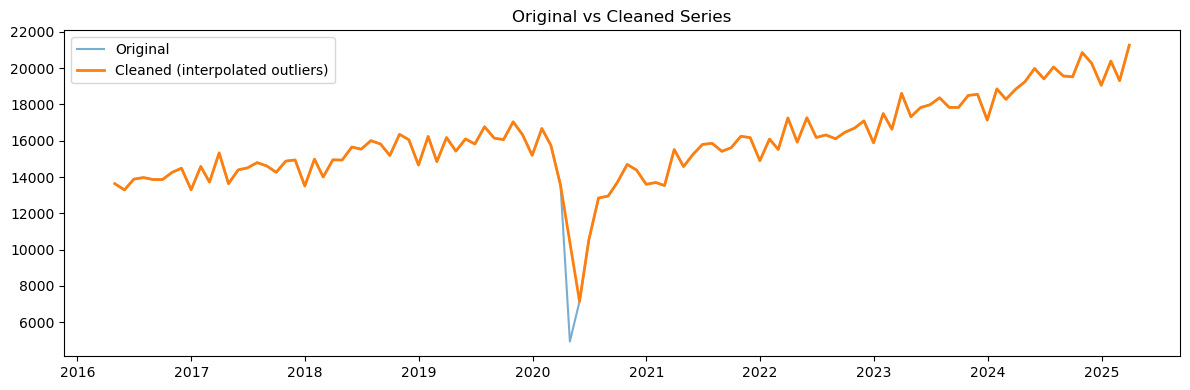

In [10]:
#Outlier smoothing via robust z on differences
diff = ts.diff()
med = diff.median()
mad = (diff - med).abs().median()
robust_z = 0.6745 * (diff - med) / (mad if mad != 0 else 1)
outlier_idx = robust_z.index[robust_z.abs() > 5]

ts_clean = ts.copy()
ts_clean.loc[outlier_idx] = np.nan
ts_clean = ts_clean.interpolate(method="time")

print(f"Outlier months replaced: {[d.date() for d in outlier_idx]}")

plt.figure(figsize=(12, 4))
plt.plot(ts, label="Original", alpha=0.6)
plt.plot(ts_clean, label="Cleaned (interpolated outliers)", linewidth=2)
plt.title("Original vs Cleaned Series")
plt.legend()
plt.tight_layout()
plt.show()


### SARIMA

d:\APPLICATIONS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                 Total Prostate MRI   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -693.374
Date:                            Thu, 21 Aug 2025   AIC                           1396.749
Time:                                    15:24:41   BIC                           1408.843
Sample:                                04-30-2016   HQIC                          1401.607
                                     - 03-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9971      0.083    -12.052      0.000      -1.159      -0.835
ma.L1          0.9652      0.069   

d:\APPLICATIONS\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


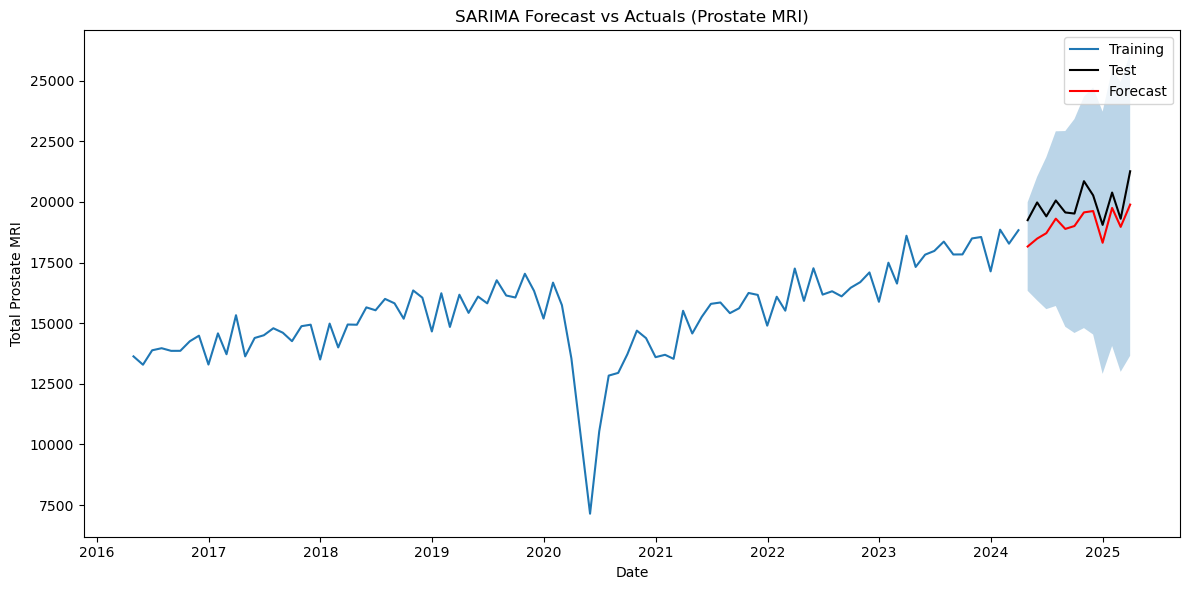

In [11]:
# SARIMA on cleaned data and backtest on last 12 months
from sklearn.metrics import mean_squared_error, mean_absolute_error

train = ts_clean.iloc[:-test_size]
test  = ts_clean.iloc[-test_size:]

sarima = sm.tsa.SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

print(sarima.summary())

fc = sarima.get_forecast(steps=len(test))
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

rmse = mean_squared_error(test, fc_mean, squared=False)
mae  = mean_absolute_error(test, fc_mean)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Training")
plt.plot(test.index,  test,  label="Test", color="black")
plt.plot(test.index,  fc_mean, label="Forecast", color="red")
plt.fill_between(test.index, fc_ci.iloc[:, 0], fc_ci.iloc[:, 1], alpha=0.3)
plt.title("SARIMA Forecast vs Actuals (Prostate MRI)")
plt.xlabel("Date")
plt.ylabel("Total Prostate MRI")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\1135021841.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_clean = ts_clean.sort_index().asfreq("M")


                                     SARIMAX Results                                      
Dep. Variable:                 Total Prostate MRI   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -788.262
Date:                            Thu, 21 Aug 2025   AIC                           1586.524
Time:                                    15:24:52   BIC                           1599.293
Sample:                                04-30-2016   HQIC                          1591.684
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9040      0.106      8.519      0.000       0.696       1.112
ma.L1         -0.9884      0.345   

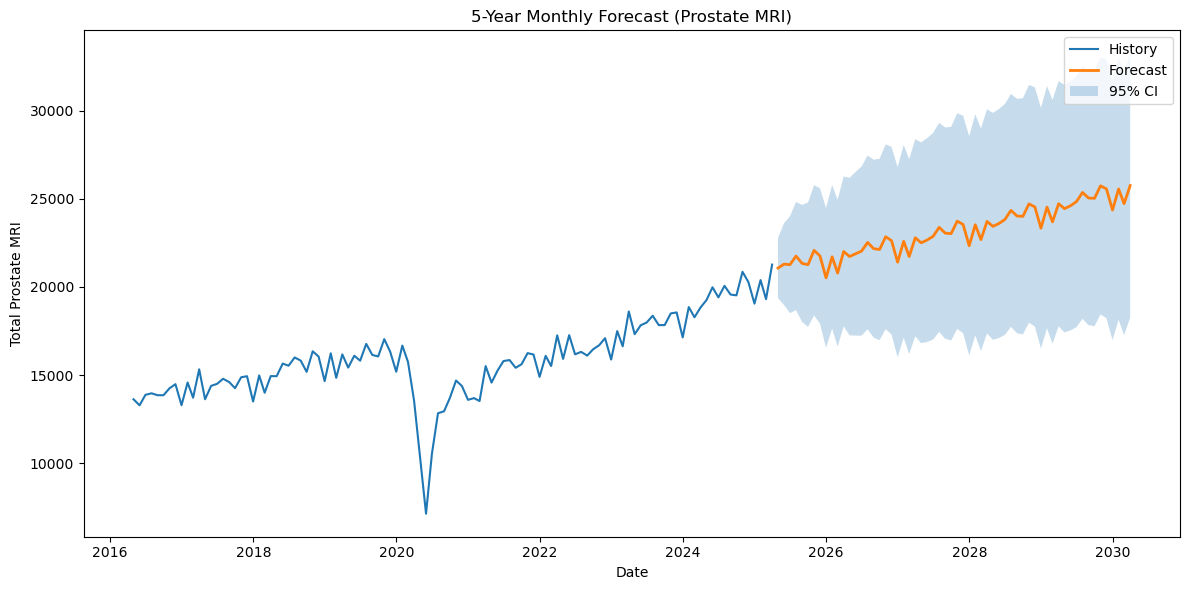

In [12]:
# Refit on full cleaned series and 5-year forecast
ts_clean = ts_clean.sort_index().asfreq("M")

final_model = sm.tsa.SARIMAX(
    ts_clean,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

print(final_model.summary())

h = 60
fc = final_model.get_forecast(steps=h)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()
ci_lower = fc_ci.iloc[:, 0]
ci_upper = fc_ci.iloc[:, 1]

forecast_df = pd.DataFrame({
    "Forecast": fc_mean,
    "Lower_95": ci_lower,
    "Upper_95": ci_upper
})
forecast_df.to_csv("prostate_mri_forecast_5y.csv", index_label="Date")

plt.figure(figsize=(12, 6))
plt.plot(ts_clean.index, ts_clean, label="History")
plt.plot(fc_mean.index, fc_mean, label="Forecast", linewidth=2)
plt.fill_between(fc_mean.index, ci_lower, ci_upper, alpha=0.25, label="95% CI")
plt.title("5-Year Monthly Forecast (Prostate MRI)")
plt.xlabel("Date")
plt.ylabel("Total Prostate MRI")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Yearly totals from monthly forecast
forecast_df = forecast_df.copy()
forecast_df.index = pd.to_datetime(forecast_df.index)
forecast_df = forecast_df.asfreq("M")

yearly_totals = (
    forecast_df[["Forecast", "Lower_95", "Upper_95"]]
    .resample("Y")
    .sum()
)

yearly_totals.index = yearly_totals.index.year
yearly_totals.index.name = "Year"

counts = forecast_df["Forecast"].resample("Y").count()
yearly_totals_full = yearly_totals[counts.values == 12]

print("Yearly totals (includes partial years):")
print(yearly_totals)
print("\nYearly totals (full 12-month years only):")
print(yearly_totals_full)

yearly_totals.to_csv("prostate_mri_forecast_yearly_totals_all.csv", index=True)
yearly_totals_full.to_csv("prostate_mri_forecast_yearly_totals_full_years_only.csv", index=True)


Yearly totals (includes partial years):
           Forecast       Lower_95       Upper_95
Year                                             
2025  192312.825064  164131.157316  220494.492812
2026  263818.112124  206365.515475  321270.708773
2027  274184.036282  203814.400060  344553.672503
2028  285708.443450  207025.299583  364391.587316
2029  297870.770709  212328.435950  383413.105469
2030   76019.738916   53658.117857   98381.359975

Yearly totals (full 12-month years only):
           Forecast       Lower_95       Upper_95
Year                                             
2026  263818.112124  206365.515475  321270.708773
2027  274184.036282  203814.400060  344553.672503
2028  285708.443450  207025.299583  364391.587316
2029  297870.770709  212328.435950  383413.105469


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\2808183298.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df = forecast_df.asfreq("M")
C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\2808183298.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")
C:\Users\PAVILION\AppData\Local\Temp\ipykernel_23588\2808183298.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  counts = forecast_df["Forecast"].resample("Y").count()
